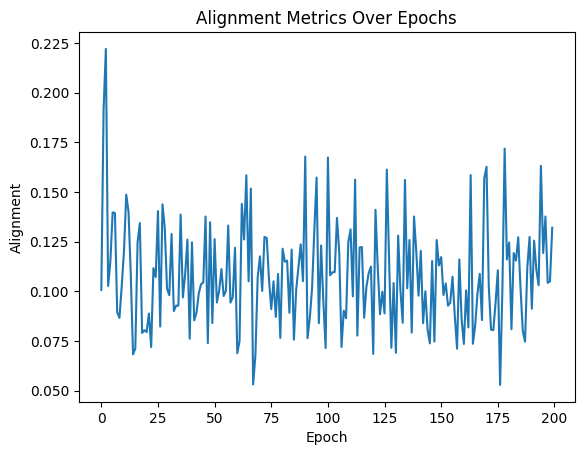

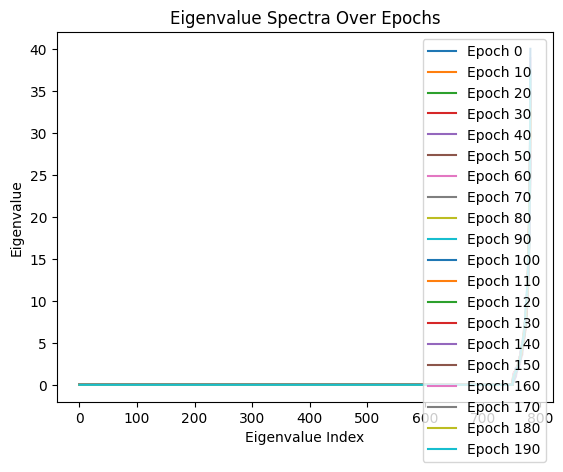

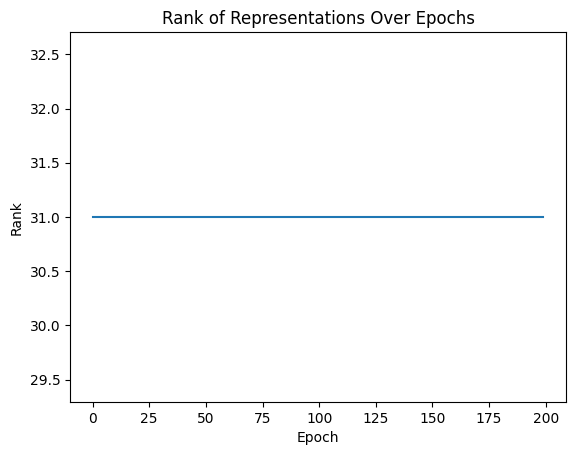

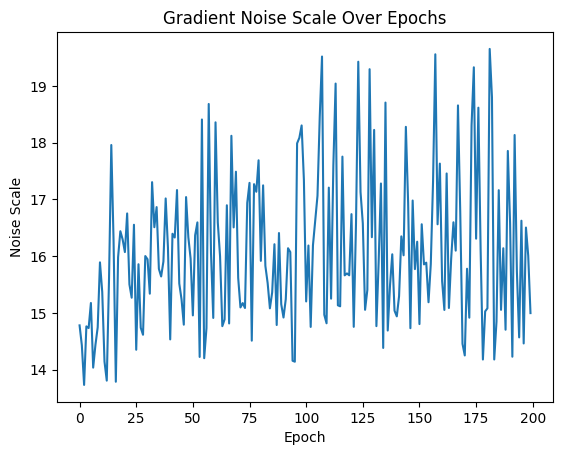

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Fixing seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define dataset loader
def load_dataset(dataset_name="MNIST", batch_size=32):
    if dataset_name == "MNIST":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        train_dataset = datasets.MNIST(root="../../data", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="../../data", train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset. Currently only 'MNIST' is supported.")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Define a simple fully connected neural network
class FullyConnectedNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

# Function to compute alignment metrics
def compute_alignment(matrix1, matrix2):
    norm1 = torch.norm(matrix1, p='fro')
    norm2 = torch.norm(matrix2, p='fro')
    alignment = torch.trace(matrix1 @ matrix2.T) / (norm1 * norm2)
    return alignment.item()

# Function to compute power-law exponents
def compute_power_law_exponent(eigenvalues):
    indices = np.arange(1, len(eigenvalues) + 1)
    slope, _, _, _, _ = linregress(np.log(indices), np.log(eigenvalues))
    return slope

# Training loop with advanced metrics logging
def train_and_log_metrics(model, dataloader, optimizer, criterion, num_epochs=10):
    alignments = []
    eigenvalue_spectra = []
    rank_history = []
    gradient_noise_scales = []

    for epoch in range(num_epochs):
        for X, y in dataloader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

        # Compute alignment metrics and eigenvalue spectra
        with torch.no_grad():
            weights = model.model[0].weight
            gradients = model.model[0].weight.grad

            # Covariance matrices
            covariance_h = torch.cov(X.view(X.size(0), -1).T)
            covariance_g = torch.cov(gradients.T)

            alignment = compute_alignment(covariance_h, covariance_g)
            alignments.append(alignment)

            eigenvalues_h = torch.linalg.eigvalsh(covariance_h).cpu().numpy()
            eigenvalue_spectra.append(eigenvalues_h)

            rank = torch.linalg.matrix_rank(covariance_h).item()
            rank_history.append(rank)

            # Gradient noise scale
            grad_norm = torch.norm(gradients)
            noise_scale = grad_norm / (torch.norm(gradients, dim=1).mean())
            gradient_noise_scales.append(noise_scale.item())

    return alignments, eigenvalue_spectra, rank_history, gradient_noise_scales

# Visualization functions
def plot_alignment(alignments):
    plt.plot(alignments)
    plt.title("Alignment Metrics Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Alignment")
    plt.show()

def plot_eigenvalues(eigenvalue_spectra):
    for epoch, eigvals in enumerate(eigenvalue_spectra):
        if epoch % 10 == 0:
            plt.plot(eigvals, label=f"Epoch {epoch}")
    plt.title("Eigenvalue Spectra Over Epochs")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.show()

def plot_rank_history(rank_history):
    plt.plot(rank_history)
    plt.title("Rank of Representations Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Rank")
    plt.show()

def plot_gradient_noise_scales(gradient_noise_scales):
    plt.plot(gradient_noise_scales)
    plt.title("Gradient Noise Scale Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Noise Scale")
    plt.show()

# Main script
if __name__ == "__main__":
    # Parameters
    input_dim = 28 * 28  # For MNIST
    hidden_dim = 128
    output_dim = 10
    batch_size = 64
    learning_rate = 0.01
    num_epochs = 200

    # Load dataset and model
    train_loader, test_loader = load_dataset("MNIST", batch_size=batch_size)

    model = FullyConnectedNet(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Train and log metrics
    alignments, eigenvalue_spectra, rank_history, gradient_noise_scales = train_and_log_metrics(
        model, train_loader, optimizer, criterion, num_epochs
    )

    # Plot results
    plot_alignment(alignments)
    plot_eigenvalues(eigenvalue_spectra)
    plot_rank_history(rank_history)
    plot_gradient_noise_scales(gradient_noise_scales)